In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, SelectFromModel
from joblib import dump, load

from utils import *
from config import X_TRAIN_MP, X_VAL_MP, Y_TRAIN_PATH, MODS_DIR, TSFM_TRAIN_DIR, TSFM_VAL_DIR

In [2]:
X_train = read_csv_mp(X_TRAIN_MP, asarray=True)
X_val = read_csv_mp(X_VAL_MP, asarray=True)
y_train = pd.read_csv(Y_TRAIN_PATH, header=None)

# Variance Filter

In [3]:
X_scaled = MinMaxScaler().fit_transform(X_train)

In [4]:
var = np.var(X_scaled, axis=0)
var.shape

(482739,)

In [5]:
thresholds = [.1, .05, 1/30, .025, .02]
for t in thresholds:
    mask = var > t
    print(f"Variance threshold: {t:.4f}\tNum. of remaining features: {X_scaled[:,mask].shape[1]}")
    save_mask(mask, 'var', 'var', t)

Variance threshold: 0.1000	Num. of remaining features: 2670
Variance threshold: 0.0500	Num. of remaining features: 9850
Variance threshold: 0.0333	Num. of remaining features: 46244
Variance threshold: 0.0250	Num. of remaining features: 168960
Variance threshold: 0.0200	Num. of remaining features: 292108


In [6]:
# TODO: saving or loading a file with only 2670-46244 cols shouldn't be so bad 
# (loading could be sped up a lot with multiprocessing)

# Correlation Filter

(refer to correlation.ipynb)

# Univariate feature selection (chi-squared, ANOVA f-test, mutual info)

In [3]:
def run_tsfm(transformer, X_train, X_val, y_train=None):
    if y_train is None:
        X_train_new = transformer.fit_transform(X_train)
    else:
        X_train_new = transformer.fit_transform(X_train, y_train)
    X_val_new = transformer.transform(X_val)
    return X_train_new, X_val_new
    
def save_tsfm(X_train, X_val, suffix):
    np.savetxt(TSFM_TRAIN_DIR/f'{suffix}.csv', X_train, delimiter=',')
    np.savetxt(TSFM_VAL_DIR/f'{suffix}.csv', X_val, delimiter=',')
    
def tsfm(transformer, X_train, X_val, suffix, **kwargs):
    save_tsfm(*run_tsfm(transformer, X_train, X_val, **kwargs), suffix)

In [9]:
v = 0.1
c = 0.95
random_state = 0
suffix = 'original'
mpath = mask_path('var', 'var', v)
# TODO streamline this (shouldn't have to apply two masks? this entire block could be put into a function?)
var_mask = np.loadtxt(mask_path('var', 'var', v), delimiter=',', dtype=bool)
var_corr_mask = np.loadtxt(mask_path('var-corr', mpath.stem+'_'+suffix, c), delimiter=',', dtype=bool)
X_train_mask = (X_train[:, var_mask])[:, var_corr_mask]
X_val_mask = (X_val[:, var_mask])[:, var_corr_mask]
print(X_train_mask.shape)

(464, 469)


In [10]:
k = 100
score_funcs = [(chi2, 'chi2'), (f_classif, 'f-test'), (mutual_info_classif, 'mutual-info')]
for score_func, suffix in score_funcs:
    transformer = SelectKBest(score_func=score_func, k=k)
    tsfm(transformer, X_train_mask, X_val_mask, suffix, y_train=np.asarray(y_train))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


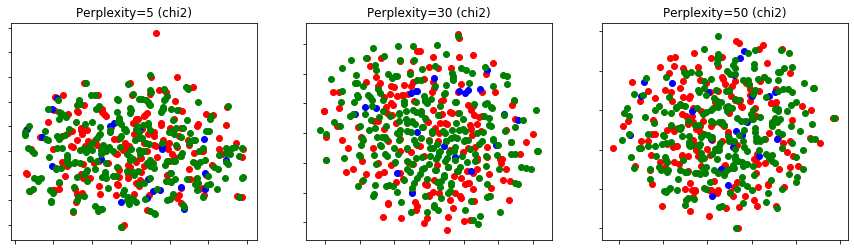

In [11]:
tsne_plot('chi2')

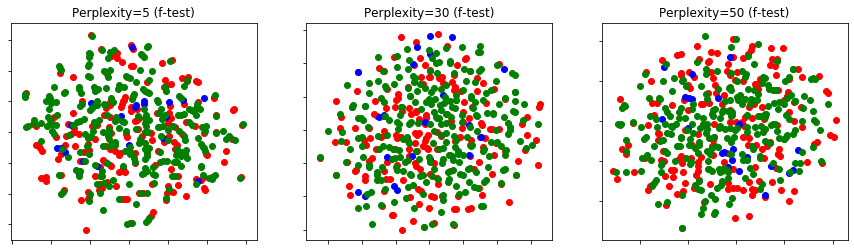

In [12]:
tsne_plot('f-test')

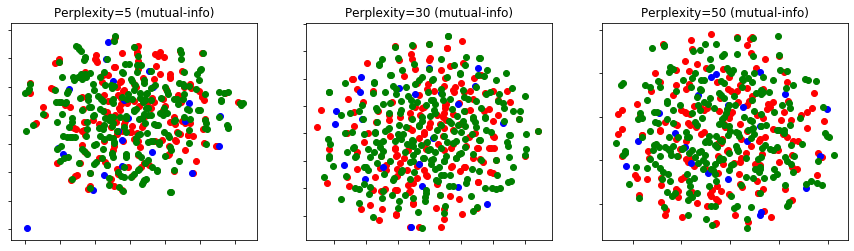

In [13]:
tsne_plot('mutual-info')

# Tree-based feature selection

In [ ]:
# https://link.springer.com/article/10.1186/s13073-015-0213-8

def rfc_model_suffix(*, n_estimators, max_depth, max_features, random_state):
    return f'rfc_{n_estimators}_{max_depth}_{max_features}_{random_state}'


def rfc_save(rfc, **kwargs):
    suffix = rfc_model_suffix(**kwargs)
    dump(rfc, MODS_DIR/f'{suffix}.sav')

    
def many_rfc_fit_save(total_estimators, max_detph, max_features, forest_size=1000):
    # TODO: check if model already exists/was saved
    iterations = total_estimators // forest_size
    for i in range(iterations):
        rfc = RandomForestClassifier(n_estimators=forest_size,
                                     max_depth=max_depth,
                                     max_features=max_features,
                                     random_state=i,
                                    )
        rfc.fit(X_train, y_train)
        
        model_suffix = rfc_model_suffix(max_depth, max_features, 1000, i)
        dump(rfc, MODS_DIR/f'{suffix}.sav')
        
        model = SelectFromModel


def rfc_dim_red(X_train, X_val, y_train,
                max_depth=None,
                max_features='sqrt',
                n_estimators=100,
                threshold='mean'):
    model = SelectFromModel(
        RandomForestClassifier(max_depth=max_depth,
                               max_features=max_features,
                               n_estimators=n_estimators,
                               random_state=0),
        threshold=threshold)
    
    model.fit(X_train, y_train)
    X_train_new = model.transform(X_train)
    X_val_new = model.transform(X_val)
    return X_train_new, X_val_new


def rfc_data_suffix(*args, threshold='mean'):
    return rfc_model_suffix(*args) + f'_{threshold}'

In [ ]:
max_depth=2
max_features=90
n_estimators=10000
threshold='mean'
random_state=0



model = SelectFromModel(
    RandomForestClassifier(max_depth=max_depth,
                           max_features=max_features,
                           n_estimators=n_estimators,
                           random_state=random_state,
                          ),
    threshold=threshold)

suffix = rfc_suffix(max_depth, max_features, n_estimators, threshold)

tsfm

X_train_new, X_val_new = rfc_dim_red(X_train, X_val, y_train,
                                     max_depth=max_depth,
                                     max_features=max_features,
                                     n_estimators=n_estimators,
                                     threshold=threshold)


save_tsfm(X_train_new, 'train', 2, 900, 10000, 'mean')
save_rfc_dim_red(X_val_new, 'val', 2, 900, 10000, 'mean')

In [ ]:
rfc = RandomForestClassifier(n_estimators=5000)
rfc.fit(X_train, y_train)